In [ ]:
import pandas as pd
from datetime import timedelta
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
# Define the file path to your dataset on Google Drive
file_path = "/content/Final_Shifted_Dataset.csv"
df = pd.read_csv(file_path)

In [ ]:
# Define the file path to your dataset on Google Drive
file_path = "/content/cleaned_uicexport_combined.csv"
df = pd.read_csv(file_path)

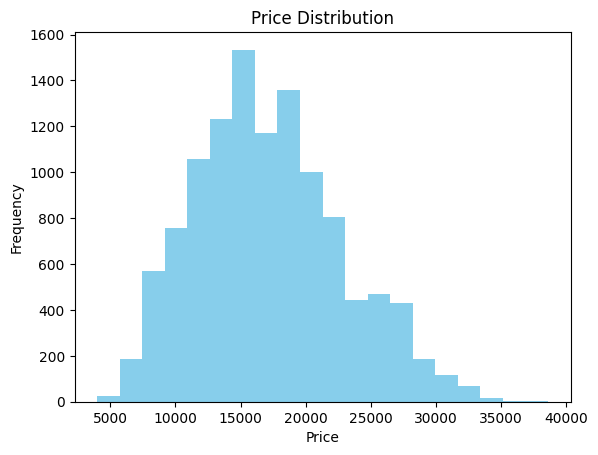

In [ ]:
plt.hist(df['PRICE'], bins=20, color='skyblue')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()


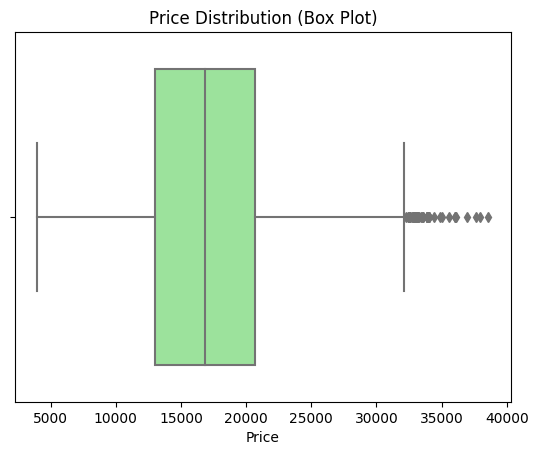

In [ ]:
sns.boxplot(x='PRICE', data=df, color='lightgreen')
plt.xlabel('Price')
plt.title('Price Distribution (Box Plot)')
plt.show()

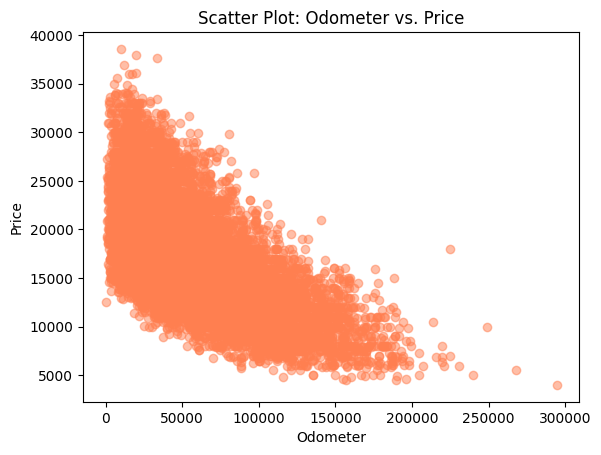

In [ ]:
plt.scatter(df['ODOMETER'], df['PRICE'], alpha=0.5, color='coral')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.title('Scatter Plot: Odometer vs. Price')
plt.show()

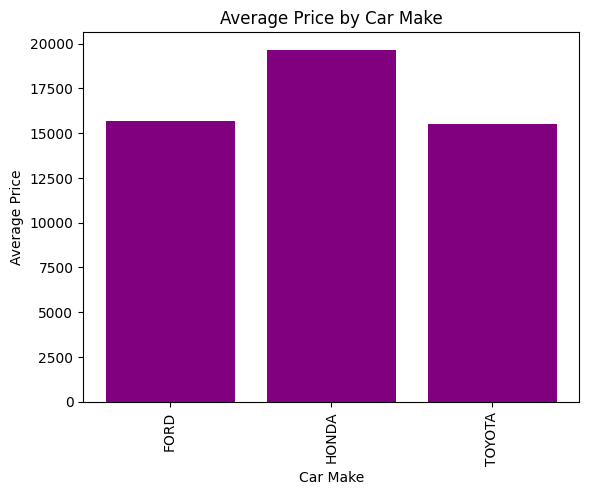

In [ ]:
avg_price_by_make = df.groupby('MAKE_NAME')['PRICE'].mean()
plt.bar(avg_price_by_make.index, avg_price_by_make.values, color='purple')
plt.xlabel('Car Make')
plt.ylabel('Average Price')
plt.title('Average Price by Car Make')
plt.xticks(rotation=90)
plt.show()

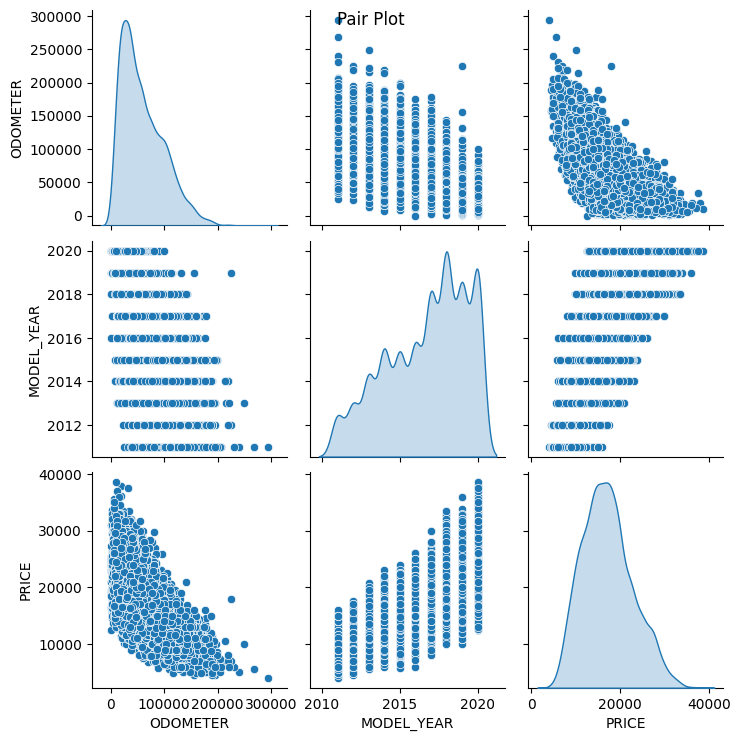

In [ ]:
sns.pairplot(df[['ODOMETER', 'MODEL_YEAR', 'PRICE']], diag_kind='kde')
plt.suptitle('Pair Plot')
plt.show()

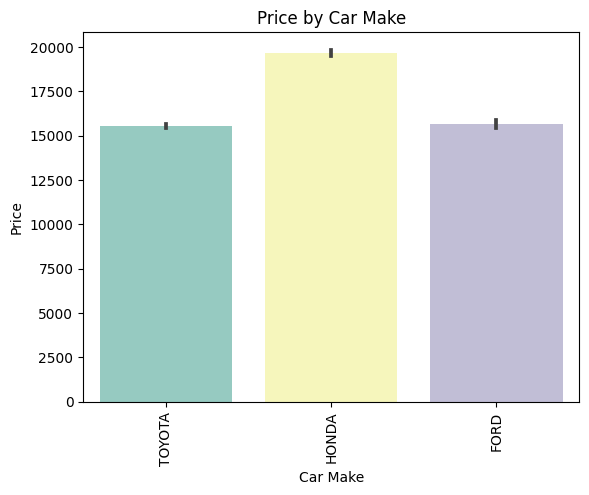

In [ ]:
sns.barplot(x='MAKE_NAME', y='PRICE', data=df, palette='Set3')
plt.xlabel('Car Make')
plt.ylabel('Price')
plt.title('Price by Car Make')
plt.xticks(rotation=90)
plt.show()


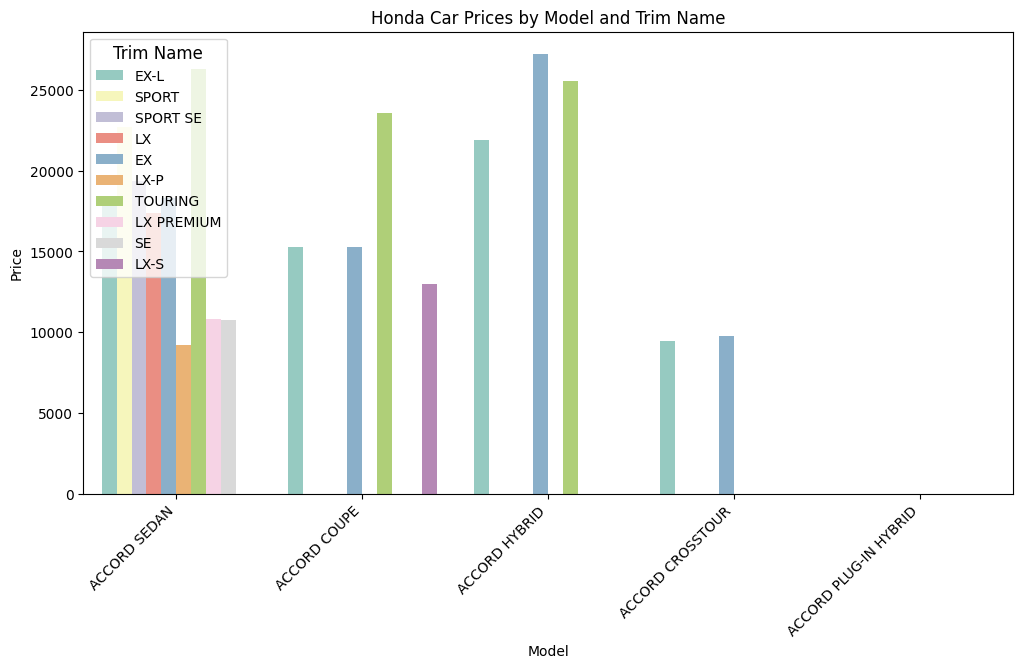

In [ ]:
# Filter the dataset for Honda cars
honda_data = df[df['MAKE_NAME'] == 'HONDA']

# Create a grouped bar plot for Model and Trim Name vs. Price
plt.figure(figsize=(12, 6))
sns.barplot(x='MODEL_NAME', y='PRICE', hue='TRIM_NAME', data=honda_data, errorbar=None, palette='Set3')
plt.xlabel('Model')
plt.ylabel('Price')
plt.title('Honda Car Prices by Model and Trim Name')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Trim Name', title_fontsize='12')
plt.show()

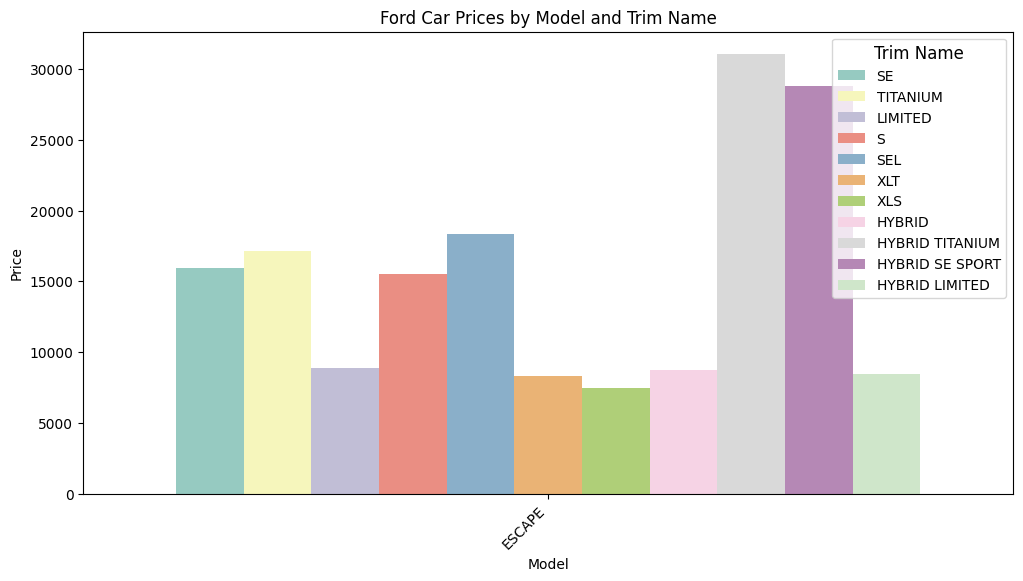

In [ ]:
# Filter the dataset for Ford cars
ford_data = df[df['MAKE_NAME'] == 'FORD']

# Create a grouped bar plot for Model and Trim Name vs. Price
plt.figure(figsize=(12, 6))
sns.barplot(x='MODEL_NAME', y='PRICE', hue='TRIM_NAME', data=ford_data, errorbar=None, palette='Set3')
plt.xlabel('Model')
plt.ylabel('Price')
plt.title('Ford Car Prices by Model and Trim Name')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Trim Name', title_fontsize='12')
plt.show()

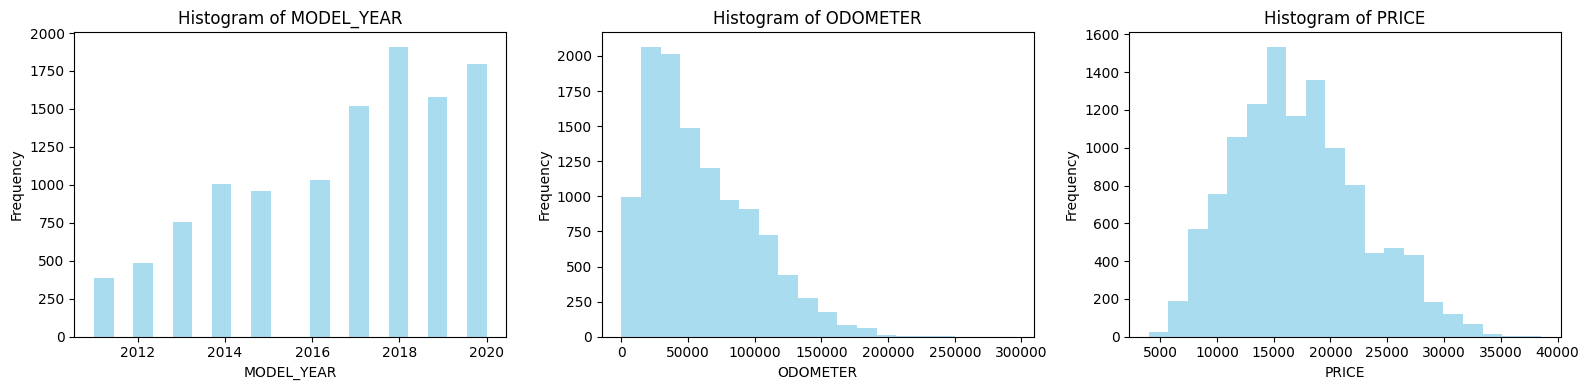

In [ ]:
# List of numeric feature column names
numeric_features = ['MODEL_YEAR', 'ODOMETER', 'PRICE']

# Set the number of subplots based on the number of features
num_subplots = len(numeric_features)
fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(16, 4))

# Create histograms for each numeric feature
for i, feature in enumerate(numeric_features):
    axes[i].hist(df[feature], bins=20, color='skyblue', alpha=0.7)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

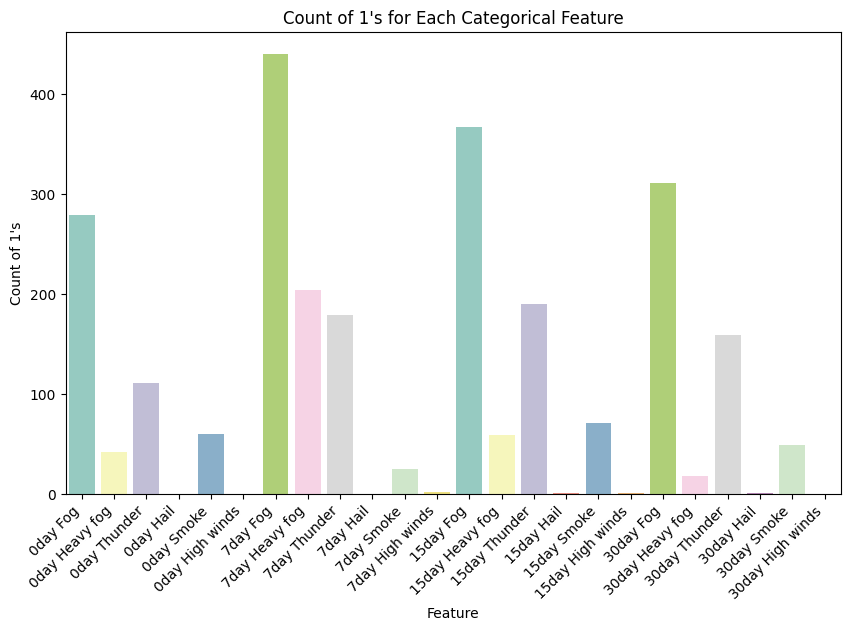

In [ ]:
# List of categorical feature column names
boolean_features = ['0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds']
# Calculate the sum of 1's for each feature
counts = df[boolean_features].sum()
# Create a bar plot for the count of 1's for each feature
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='Set3')
plt.title('Count of 1\'s for Each Categorical Feature')
plt.xlabel('Feature')
plt.ylabel('Count of 1\'s')
plt.xticks(rotation=45, ha='right')
plt.show()

FINDING MISSING VALUES

In [ ]:
missing_values = df.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values and their counts
print("Columns with missing values and their counts:")
print(columns_with_missing_values)

Columns with missing values and their counts:
TRIM_NAME       87
STYLE_NAME     114
0day PRCP     4957
7day PRCP     4952
15day PRCP    4999
30day PRCP    4823
dtype: int64


IMPUTUNING MISSING VALUES IN TRIM_NAME WITH MODE

In [ ]:
mode_value = df['TRIM_NAME'].mode().iloc[0]

# Impute missing values with the mode
df['TRIM_NAME'].fillna(mode_value, inplace=True)


IMPUTING MISSING WEATHER DATA BASED ON ZIPCODE AND DATE RANGE

In [ ]:
# Convert 'AD_DATE' to datetime format
df['AD_DATE'] = pd.to_datetime(df['AD_DATE'])

# Define a function to calculate the range of ZIP_CODE values within plus or minus 5
def zip_code_range(zip_code):
    zip_code = int(zip_code)
    return range(zip_code - 5, zip_code + 6)

# Define a function to calculate the date range within plus or minus 1 day
def date_range(date):
    return (date - timedelta(days=1), date + timedelta(days=1))

# Apply the functions to create 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns
df['ZIP_CODE_RANGE'] = df['ZIP_CODE'].apply(zip_code_range)
df['DATE_RANGE'] = df['AD_DATE'].apply(date_range)

# Iterate through the rows to impute missing 'PRCP' values
for index, row in df.iterrows():
    if pd.isna(row['0day PRCP']):
        # Find rows with 'PRCP' values in the calculated 'ZIP_CODE_RANGE' and 'DATE_RANGE'
        similar_rows = df[(df['ZIP_CODE'].isin(row['ZIP_CODE_RANGE'])) &
                                   (df['AD_DATE'].between(*row['DATE_RANGE']))]

        if not similar_rows.empty:
            # Calculate the average 'PRCP' value from similar rows
            avg_PRCP = similar_rows['0day PRCP'].mean()
            # Impute the missing 'PRCP' value
            df.at[index, '0day PRCP'] = avg_PRCP

# Drop the 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns if you no longer need them
df.drop(['ZIP_CODE_RANGE', 'DATE_RANGE'], axis=1, inplace=True)

In [ ]:
# Convert 'AD_DATE' to datetime format
df['AD_DATE'] = pd.to_datetime(df['AD_DATE'])

# Define a function to calculate the range of ZIP_CODE values within plus or minus 5
def zip_code_range(zip_code):
    zip_code = int(zip_code)
    return range(zip_code - 5, zip_code + 6)

# Define a function to calculate the date range within plus or minus 1 day
def date_range(date):
    return (date - timedelta(days=1), date + timedelta(days=1))

# Apply the functions to create 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns
df['ZIP_CODE_RANGE'] = df['ZIP_CODE'].apply(zip_code_range)
df['DATE_RANGE'] = df['AD_DATE'].apply(date_range)

# Iterate through the rows to impute missing 'PRCP' values
for index, row in df.iterrows():
    if pd.isna(row['7day PRCP']):
        # Find rows with 'PRCP' values in the calculated 'ZIP_CODE_RANGE' and 'DATE_RANGE'
        similar_rows = df[(df['ZIP_CODE'].isin(row['ZIP_CODE_RANGE'])) &
                                   (df['AD_DATE'].between(*row['DATE_RANGE']))]

        if not similar_rows.empty:
            # Calculate the average 'PRCP' value from similar rows
            avg_PRCP = similar_rows['7day PRCP'].mean()
            # Impute the missing 'PRCP' value
            df.at[index, '7day PRCP'] = avg_PRCP

# Drop the 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns if you no longer need them
df.drop(['ZIP_CODE_RANGE', 'DATE_RANGE'], axis=1, inplace=True)

In [ ]:
# Convert 'AD_DATE' to datetime format
df['AD_DATE'] = pd.to_datetime(df['AD_DATE'])

# Define a function to calculate the range of ZIP_CODE values within plus or minus 5
def zip_code_range(zip_code):
    zip_code = int(zip_code)
    return range(zip_code - 5, zip_code + 6)

# Define a function to calculate the date range within plus or minus 1 day
def date_range(date):
    return (date - timedelta(days=1), date + timedelta(days=1))

# Apply the functions to create 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns
df['ZIP_CODE_RANGE'] = df['ZIP_CODE'].apply(zip_code_range)
df['DATE_RANGE'] = df['AD_DATE'].apply(date_range)

# Iterate through the rows to impute missing 'PRCP' values
for index, row in df.iterrows():
    if pd.isna(row['15day PRCP']):
        # Find rows with 'PRCP' values in the calculated 'ZIP_CODE_RANGE' and 'DATE_RANGE'
        similar_rows = df[(df['ZIP_CODE'].isin(row['ZIP_CODE_RANGE'])) &
                                   (df['AD_DATE'].between(*row['DATE_RANGE']))]

        if not similar_rows.empty:
            # Calculate the average 'PRCP' value from similar rows
            avg_PRCP = similar_rows['15day PRCP'].mean()
            # Impute the missing 'PRCP' value
            df.at[index, '15day PRCP'] = avg_PRCP

# Drop the 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns if you no longer need them
df.drop(['ZIP_CODE_RANGE', 'DATE_RANGE'], axis=1, inplace=True)

In [ ]:
# Convert 'AD_DATE' to datetime format
df['AD_DATE'] = pd.to_datetime(df['AD_DATE'])

# Define a function to calculate the range of ZIP_CODE values within plus or minus 5
def zip_code_range(zip_code):
    zip_code = int(zip_code)
    return range(zip_code - 5, zip_code + 6)

# Define a function to calculate the date range within plus or minus 1 day
def date_range(date):
    return (date - timedelta(days=1), date + timedelta(days=1))

# Apply the functions to create 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns
df['ZIP_CODE_RANGE'] = df['ZIP_CODE'].apply(zip_code_range)
df['DATE_RANGE'] = df['AD_DATE'].apply(date_range)

# Iterate through the rows to impute missing 'PRCP' values
for index, row in df.iterrows():
    if pd.isna(row['30day PRCP']):
        # Find rows with 'PRCP' values in the calculated 'ZIP_CODE_RANGE' and 'DATE_RANGE'
        similar_rows = df[(df['ZIP_CODE'].isin(row['ZIP_CODE_RANGE'])) &
                                   (df['AD_DATE'].between(*row['DATE_RANGE']))]

        if not similar_rows.empty:
            # Calculate the average 'PRCP' value from similar rows
            avg_PRCP = similar_rows['30day PRCP'].mean()
            # Impute the missing 'PRCP' value
            df.at[index, '30day PRCP'] = avg_PRCP

# Drop the 'ZIP_CODE_RANGE' and 'DATE_RANGE' columns if you no longer need them
df.drop(['ZIP_CODE_RANGE', 'DATE_RANGE'], axis=1, inplace=True)

REPLACING REMAINING MISSING PRCP VALUES WITH 0

In [ ]:
columns_to_replace = ['0day PRCP','7day PRCP','15day PRCP','30day PRCP']
df[columns_to_replace] = df[columns_to_replace].fillna(0)

REPLACING MISSING VALUES IN TRIM_NAME AND STYLE_NAME WITH MODE

In [ ]:
mode_value = df['TRIM_NAME'].mode().iloc[0]
df['TRIM_NAME'].fillna(mode_value, inplace=True)

mode_value = df['STYLE_NAME'].mode().iloc[0]
df['STYLE_NAME'].fillna(mode_value, inplace=True)

DATA CLEANING, FEATURE ENGINEERING, EDA etc has ended here are the final csv is saved.
A SMALL PART OF DATA CLEANING WAS DONE USING MS-EXCEL

DO NOT RERUN THE ABOVE CODE ON THE FINAL CSV FILE.

IMPORTING THE FINAL CSV FILE TO RUN THE ML MODELS

In [ ]:
# Define the file path to your dataset on Google Drive
file_path = "/content/Final_Shifted_Dataset.csv"
df = pd.read_csv(file_path)

CREATING SUBSETS OF THE DATAFRAME

---
We created different combinations of Shifted Weather data.


---
df1 = 0 days shift

df2 = 7 days shift

df3 = 15 days shift

df4 = 30 days shift

df5 = 0 & 7 days shifts together

df6 = 0 & 30 days shifts together

df7 = 15 & 30 days shifts together

df8 =  7 & 15 days shifts together

df9 = 7 ,15 & 30 days shifts together





---







CREATING DATAFRAMES WITH DIFFERENT COMBINATIONS OF SHIFTED WEATHER DATA

In [ ]:
df1 = df.drop(['7day PRCP','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds','15day PRCP','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds','30day PRCP','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds'], axis=1)
df2 = df.drop(['0day PRCP','0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds','15day PRCP','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds','30day PRCP','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds'], axis=1)
df3 = df.drop(['0day PRCP','0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds','7day PRCP','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds','30day PRCP','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds'], axis=1)
df4 = df.drop(['0day PRCP','0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds','7day PRCP','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds','15day PRCP','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds'], axis=1)
df5 = df.drop(['15day PRCP','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds','30day PRCP','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds'], axis=1)
df6 = df.drop(['0day PRCP','0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds','30day PRCP','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds'], axis=1)
df7 = df.drop(['0day PRCP','0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds','7day PRCP','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds'], axis=1)
df8 = df.drop(['7day PRCP','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds','15day PRCP','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds'], axis=1)
df9 = df.drop(['0day PRCP','0day Fog', '0day Heavy fog', '0day Thunder', '0day Hail', '0day Smoke', '0day High winds'], axis=1)
df10 = df.drop(['15day PRCP','15day Fog', '15day Heavy fog', '15day Thunder', '15day Hail', '15day Smoke', '15day High winds'], axis=1)
df11 = df.drop(['7day PRCP','7day Fog', '7day Heavy fog', '7day Thunder', '7day Hail', '7day Smoke', '7day High winds'], axis=1)
df12 = df.drop(['30day PRCP','30day Fog', '30day Heavy fog', '30day Thunder', '30day Hail', '30day Smoke', '30day High winds'], axis=1)

LINEAR REGRESSION FOR ALL THE DIFFERENT DATSETS

In [ ]:
# Create an empty dictionary to store results
results = {}

# Loop through each DataFrame
for i in range(2, 13):
    # Assuming you have df1, df2, ..., df9 DataFrames
    df = globals()[f'df{i}']

    # Separate features and target variable
    X = df.drop('PRICE', axis=1)
    y = df['PRICE']

    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Identify numeric columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

    # Create transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Create a linear regression model
    model = LinearRegression()

    # Create a pipeline with the column transformer and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', model)])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = pipeline.predict(X_test)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Calculate R-squared value
    r2 = r2_score(y_test, y_pred)

    # Store the results in the dictionary
    results[f'df{i}'] = {'RMSE': rmse, 'R-squared': r2}

# Print or further analyze the results
for df_name, metrics in results.items():
    print(f"Results for {df_name}:")
    print(f"  RMSE: {metrics['RMSE']}")
    print(f"  R-squared: {metrics['R-squared']}")
    print("\n")


Results for df2:
  RMSE: 2236.508954288809
  R-squared: 0.8429160670090112


Results for df3:
  RMSE: 2467.17122433286
  R-squared: 0.8088435018838556


Results for df4:
  RMSE: 2462.2645233576877
  R-squared: 0.8096030884686436


Results for df5:
  RMSE: 2241.275383751896
  R-squared: 0.8422458015687537


Results for df6:
  RMSE: 2240.3508998963707
  R-squared: 0.8423759159958097


Results for df7:
  RMSE: 2462.297760582036
  R-squared: 0.8095979482349155


Results for df8:
  RMSE: 2075.5528841344294
  R-squared: 0.8647123693812379


Results for df9:
  RMSE: 2229.3221809574843
  R-squared: 0.8439239885539092


Results for df10:
  RMSE: 2234.972067048223
  R-squared: 0.8431318831291221


Results for df11:
  RMSE: 2464.3173357086603
  R-squared: 0.8092854848520468


Results for df12:
  RMSE: 2235.279882948954
  R-squared: 0.8430886702169083




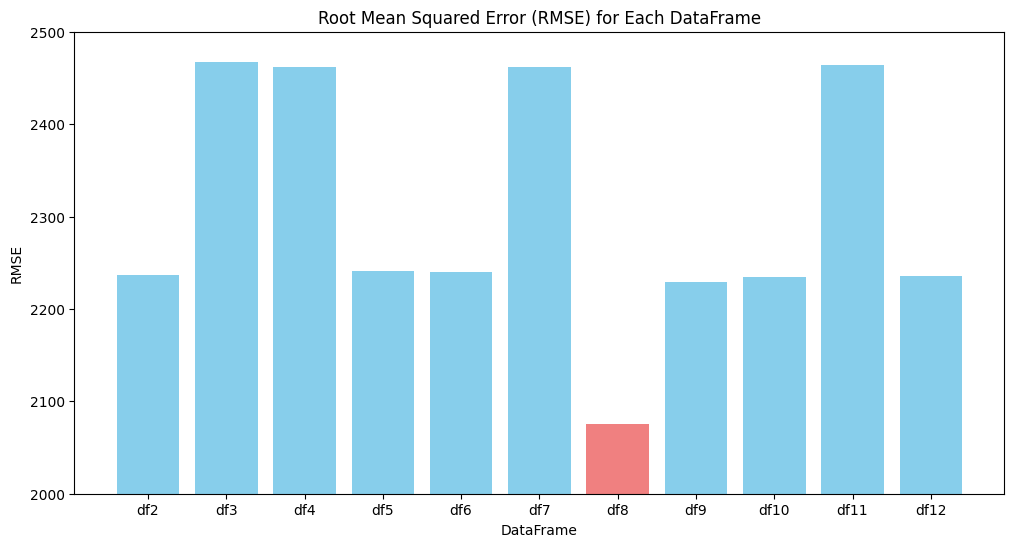

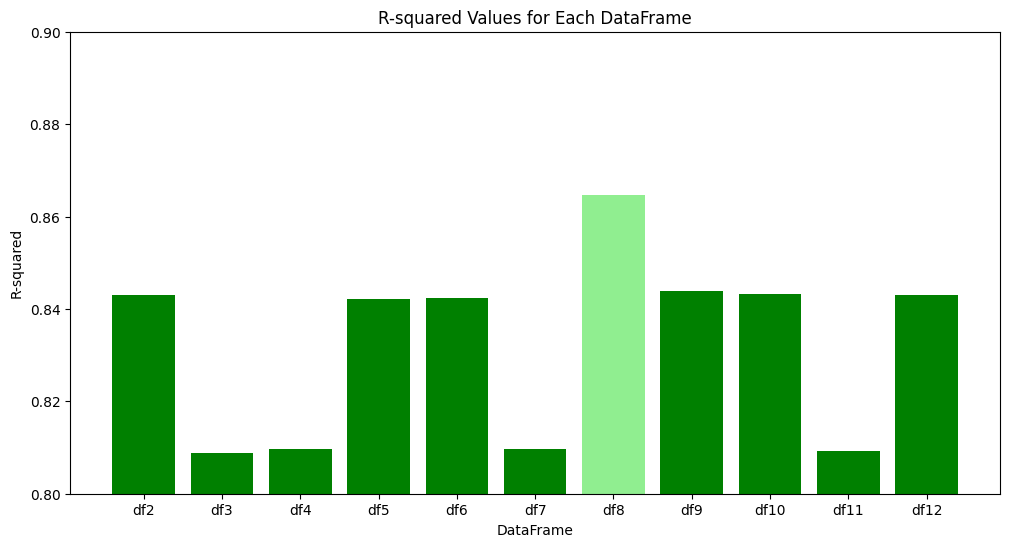

In [ ]:
# Extract DataFrame names and corresponding metrics
df_names = list(results.keys())
rmse_values = [metrics['RMSE'] for metrics in results.values()]
r2_values = [metrics['R-squared'] for metrics in results.values()]

# Find the index of the DataFrame with the highest R-squared value
max_r2_index = np.argmax(r2_values)

# Plot bar chart for RMSE
plt.figure(figsize=(12, 6))
bar_colors = ['skyblue' if i != max_r2_index else 'lightcoral' for i in range(len(df_names))]
plt.bar(df_names, rmse_values, color=bar_colors)
plt.xlabel('DataFrame')
plt.ylabel('RMSE')
plt.ylim(2000, 2500)  # Set the y-axis range
plt.title('Root Mean Squared Error (RMSE) for Each DataFrame')
plt.show()

# Plot bar chart for R-squared
plt.figure(figsize=(12, 6))
bar_colors = ['lightgreen' if i == max_r2_index else 'green' for i in range(len(df_names))]
plt.bar(df_names, r2_values, color=bar_colors)
plt.xlabel('DataFrame')
plt.ylabel('R-squared')
plt.ylim(0.8, 0.9)  # Set the y-axis range
plt.title('R-squared Values for Each DataFrame')
plt.show()



XGBOOST REGRESSOR FOR DIFFERENT DATAFRAMES


In [ ]:
# Create an empty dictionary to store results
results = {}

# Loop through each DataFrame
for i in range(2, 13):
    # Assuming you have df1, df2, ..., df9 DataFrames
    df = globals()[f'df{i}']

    # Assuming 'df' is your DataFrame
    # Separate features and target variable
    X = df.drop('PRICE', axis=1)
    y = df['PRICE']

    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # Identify numeric columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

    # Create transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Create an XGBoost regressor
    model = XGBRegressor()

    # Create a pipeline with the column transformer and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', model)])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the testing data
    y_pred = pipeline.predict(X_test)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Calculate R-squared value
    r2 = r2_score(y_test, y_pred)

    # Store the results in the dictionary
    results[f'df{i}'] = {'RMSE': rmse, 'R-squared': r2}

# Print or further analyze the results
for df_name, metrics in results.items():
    print(f"Results for {df_name}:")
    print(f"  RMSE: {metrics['RMSE']}")
    print(f"  R-squared: {metrics['R-squared']}")
    print("\n")


Results for df2:
  RMSE: 1665.6552477548403
  R-squared: 0.9128714034320997


Results for df3:
  RMSE: 1658.398358844957
  R-squared: 0.9136289493767451


Results for df4:
  RMSE: 1655.5739293311892
  R-squared: 0.9139228970976446


Results for df5:
  RMSE: 1673.1965150816502
  R-squared: 0.9120806666194485


Results for df6:
  RMSE: 1664.4453501634316
  R-squared: 0.9129979342889771


Results for df7:
  RMSE: 1658.6084022738814
  R-squared: 0.9136070694461518


Results for df8:
  RMSE: 1641.2108449597372
  R-squared: 0.9154099581227818


Results for df9:
  RMSE: 1654.6749270795242
  R-squared: 0.9140163541130447


Results for df10:
  RMSE: 1658.271825188429
  R-squared: 0.9136421288735372


Results for df11:
  RMSE: 1672.8223101986007
  R-squared: 0.9121199879598867


Results for df12:
  RMSE: 1674.3409233184725
  R-squared: 0.9119603579561463




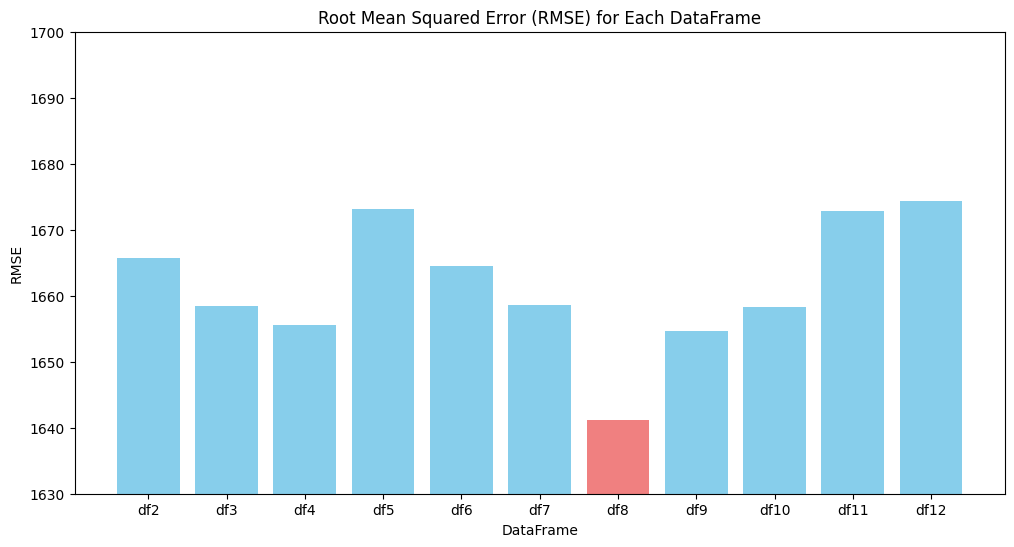

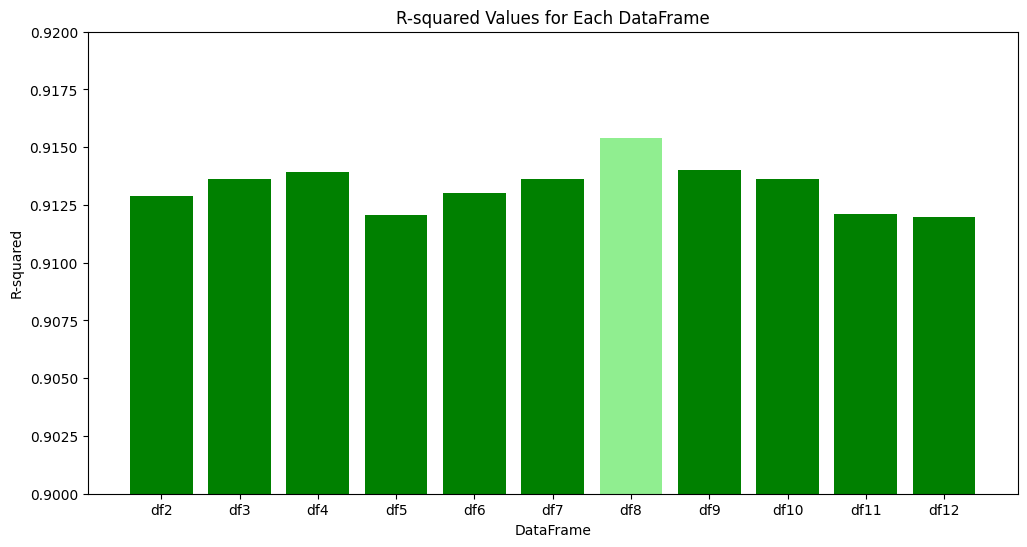

In [ ]:
# Extract DataFrame names and corresponding metrics
df_names = list(results.keys())
rmse_values = [metrics['RMSE'] for metrics in results.values()]
r2_values = [metrics['R-squared'] for metrics in results.values()]

# Find the index of the DataFrame with the highest R-squared value
max_r2_index = np.argmax(r2_values)

# Plot bar chart for RMSE
plt.figure(figsize=(12, 6))
bar_colors = ['skyblue' if i != max_r2_index else 'lightcoral' for i in range(len(df_names))]
plt.bar(df_names, rmse_values, color=bar_colors)
plt.xlabel('DataFrame')
plt.ylabel('RMSE')
plt.ylim(1630, 1700)  # Set the y-axis range
plt.title('Root Mean Squared Error (RMSE) for Each DataFrame')
plt.show()

# Plot bar chart for R-squared
plt.figure(figsize=(12, 6))
bar_colors = ['lightgreen' if i == max_r2_index else 'green' for i in range(len(df_names))]
plt.bar(df_names, r2_values, color=bar_colors)
plt.xlabel('DataFrame')
plt.ylabel('R-squared')
plt.ylim(0.9, 0.92)  # Set the y-axis range
plt.title('R-squared Values for Each DataFrame')
plt.show()
